In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns

np.set_printoptions(suppress=True)

import bayesflow as bf
import tensorflow as tf

from numba import njit

from functools import partial
from bayesflow.simulation import Prior, Simulator, GenerativeModel

# Vicsek model: averaged

This notebook provides a baseline, flat estimate for averaged agent direction in the Vicsek model.

In [39]:
param_names = [r'$r$', r'$v$']

@njit
def prior_fun():
        
    r = np.random.gamma(2., 2.)
    v = np.random.gamma(2., 2.)
    
    return np.array([r, v], dtype=np.float64)

In [40]:
test_prior = prior_fun()
test_prior

array([10.38065634,  2.91239158])

In [41]:
@njit
def initialize_agents(
    num_agents=12,
    boundary_size=10.0,
):

    positions = np.random.random(size=(num_agents, 2)) * boundary_size
    directions = np.random.random(size=num_agents) * np.pi

    return positions, directions

In [42]:
positions, directions = initialize_agents()
positions

array([[6.33720858, 8.15221434],
       [5.56512595, 6.60253605],
       [9.15477052, 2.24159596],
       [2.00969931, 8.01428644],
       [7.89922157, 2.46380007],
       [8.46701842, 6.67420827],
       [3.16865937, 8.0509907 ],
       [9.73905819, 8.56010744],
       [7.25849184, 3.59611872],
       [2.69845211, 5.24294795],
       [0.50456663, 3.11275651],
       [3.5948942 , 8.77393372]])

In [44]:
@njit
def simulator_fun(
    theta,
    num_agents=12,
    num_timesteps=100,
    boundary_size=10.0,
    averaged = True
):
    # Unpack priors
    radius, speed = theta[0], theta[1]
    
    # Store trajectories and headings
    trajectories = np.zeros((num_timesteps + 1, num_agents, 2), dtype=np.float32)
    headings = np.zeros((num_timesteps + 1, num_agents, 1), dtype=np.float32)
    
    # Initialize positions and directions for each agent
    positions, directions = initialize_agents(num_agents, boundary_size)
    trajectories[0] = positions
    headings[0] = directions[:, np.newaxis]
    
    # Loop over each timestep
    for t in range(num_timesteps):
        # For each timestep, initialize directions for the agents
        new_directions = np.zeros(num_agents)
        
        # For each agent, collect neighbors within its sensing range
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            # If there are any neighbors, average over their directions 
            # and assign it as the new direction. 
            if neighbors:
                avg_direction = np.mean(np.array(neighbors))
                new_directions[i] = avg_direction + np.random.uniform(-0.01, 0.01)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        
        # Update position upon new direction
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.sin(directions)
        
        # Assumes periodic boundary condition
        positions = np.mod(positions, boundary_size)
        
        # Add snapshot of positions and directions as part of trajectory
        trajectories[t + 1] = np.copy(positions)
        headings[t + 1] = np.copy(directions[:, np.newaxis])
    
    averaged_trajectories = np.average(trajectories, axis=1)
    averaged_headings = np.average(headings, axis=1)
    
    if averaged:
        return np.concatenate((averaged_trajectories, averaged_headings))
    else:
        return np.concatenate((trajectories, headings), axis=-1)

In [46]:
paths = simulator_fun(theta=test_prior, averaged=False)
paths.shape

TypeError: np.concatenate(): expecting a non-empty tuple of arrays, got UniTuple(float64 x 2)

# Generative Model

In [8]:
prior = Prior(prior_fun=prior_fun)

simulator = Simulator(simulator_fun=simulator_fun)

model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Vicsek")

INFO:root:Performing 2 pilot runs with the Vicsek model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Configurator

In [9]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

In [10]:
# class StackedLSTM(tf.keras.Model):
#     def __init__(self, summary_dim=32, lstm_units=512, hidden_units=512, dropout=0.05):
#         super().__init__()
        
#         self.mlp = tf.keras.Sequential([
#             tf.keras.layers.Dense(hidden_units, activation="mish"),
#             tf.keras.layers.Dropout(dropout),
#             tf.keras.layers.Dense(hidden_units // 16)
#         ])
#         self.lstm = tf.keras.layers.LSTM(lstm_units, dropout=dropout)
#         self.projector = tf.keras.layers.Dense(summary_dim)
        
#     def call(self, x, **kwargs):
        
#         old_shape = tf.shape(x)
#         x = tf.reshape(x, shape=(old_shape[0], old_shape[1], -1))
#         embeddings = self.mlp(x, **kwargs)
#         rep = self.lstm(embeddings, **kwargs)
#         proj = self.projector(rep)
#         return proj

# Neural Approximator

In [18]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

In [23]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=5,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)


trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Online Training

In [36]:
history = trainer.train_online(epochs=50, batch_size=32, iterations_per_epoch=500)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/500 [00:00<?, ?it/s]

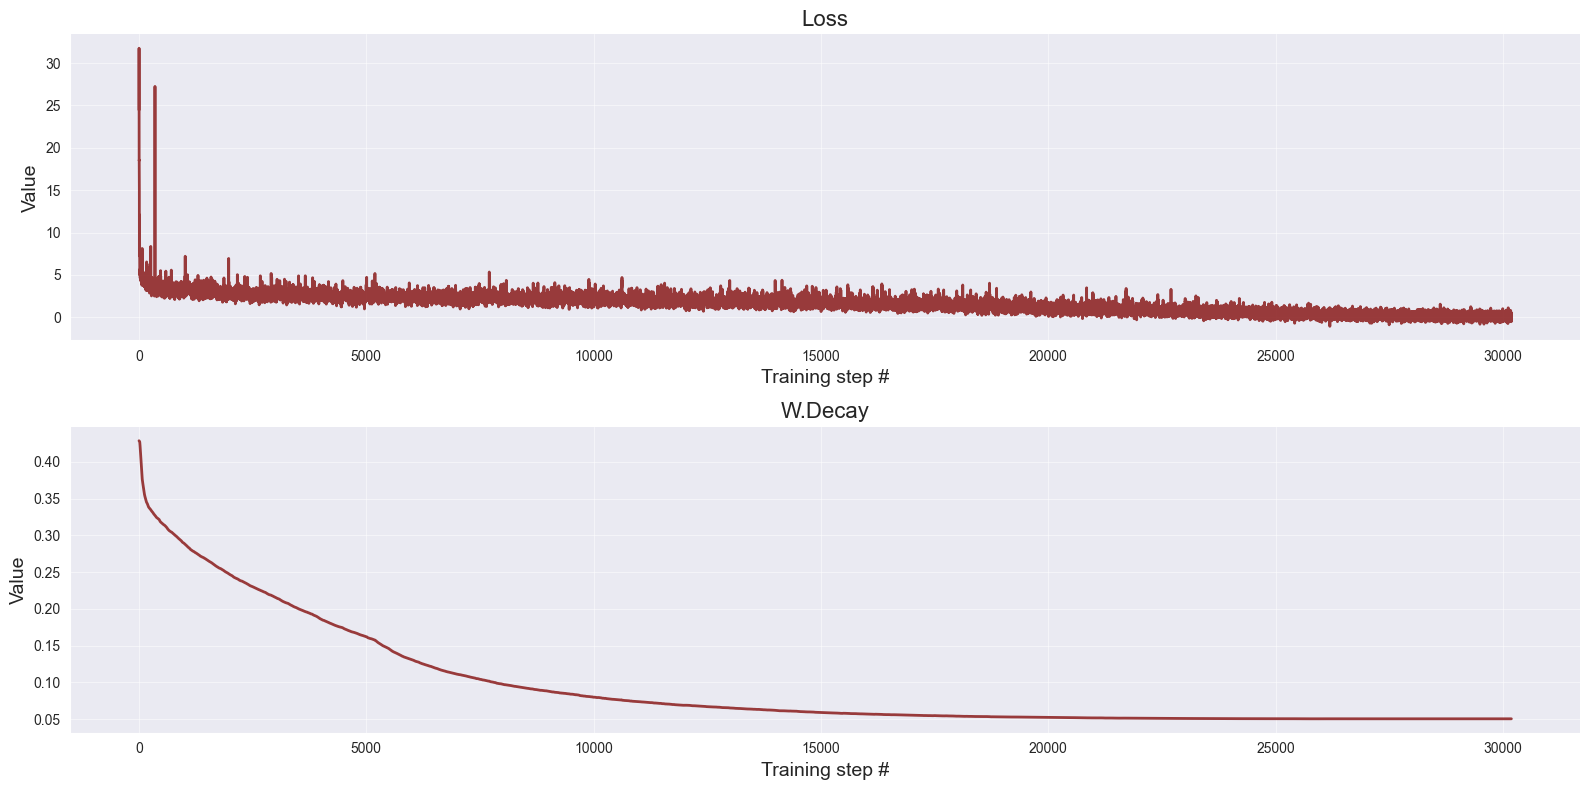

In [37]:
f = bf.diagnostics.plot_losses(history)

# Validation

In [41]:
validation_sim = model(400)
validation_configured = configurator(validation_sim)

In [42]:
post_samples = amortizer.sample(validation_configured, n_samples=1000)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

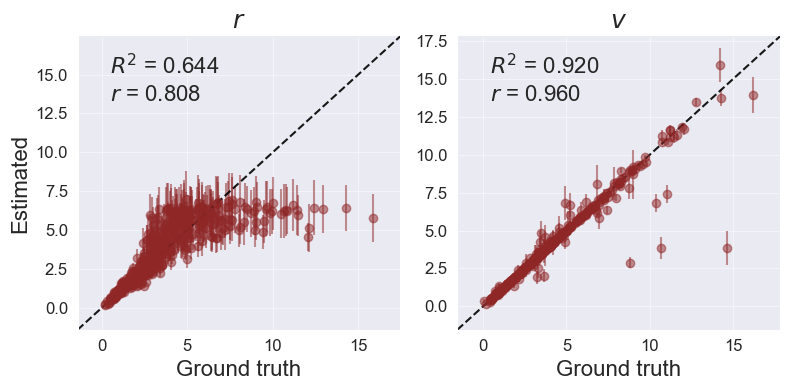

In [43]:
g = bf.diagnostics.plot_recovery(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names
)

The drift $v$ shows near-perfect recovery, followed by the noise parameter $\eta$.

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


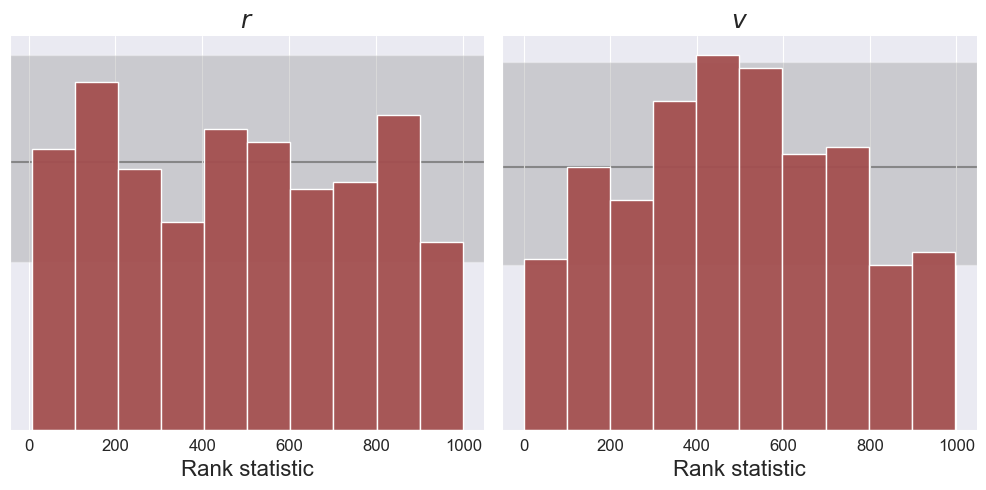

In [44]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

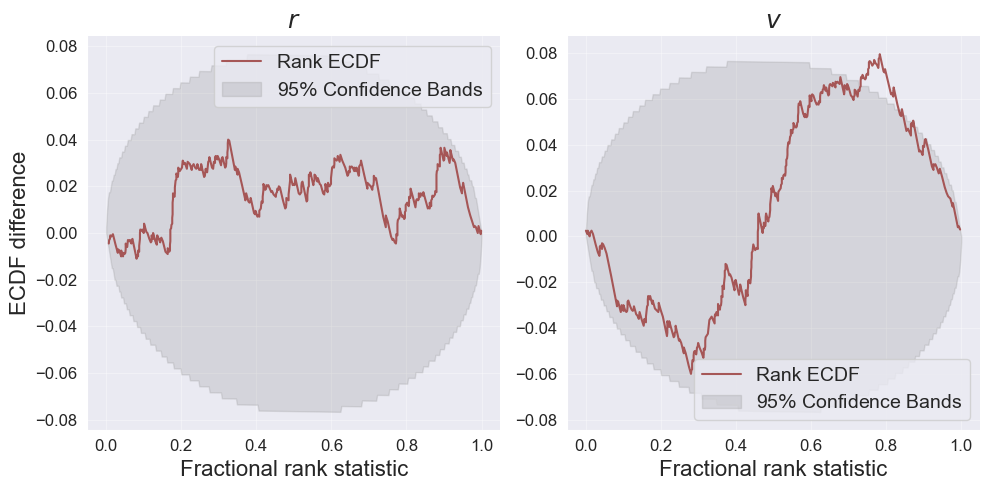

In [45]:
e = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, difference=True)

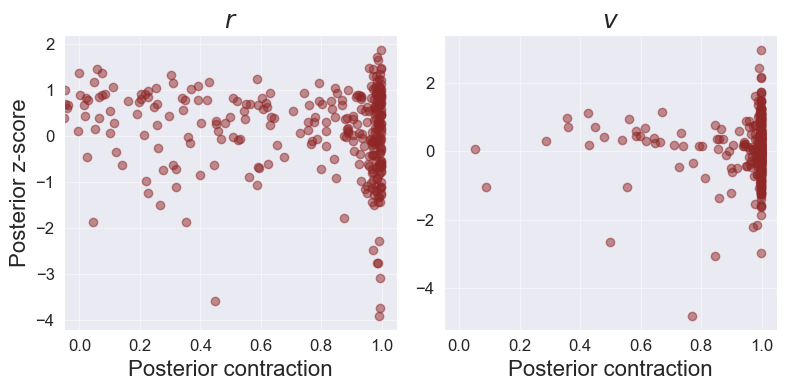

In [46]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)